In [1]:
# Colab specific setup
try:
  from google.colab import drive
  
except Exception:
  # Local setup
  rootpath = "."

else:
  drive.mount('/content/drive')
  rootpath = '/content/drive/My Drive/6.869/pytorch-vqa-abs'

Mounted at /content/drive


In [2]:
import torch
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


In [3]:
!nvidia-smi

Wed May 11 03:27:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pwd
import os 
os.chdir(rootpath)
!pwd

/content
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs


#### Process the images 
Use Restnet18 to compute the high level representation of the input image. The last layer of Resnet18 before the final pooling layer is used.

In [ ]:
!python3 preprocess-images.py

20000
found 20000 images in ../image_dataset_abs/train2015
10000
found 10000 images in ../image_dataset_abs/val2015
  0% 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100% 938/938 [26:08<00:00,  1.67s/it]


#### Process the questions and answers.  

In [ ]:
!python3 preprocess-vocab.py


### Train the model

In [ ]:
!python3 train.py S+CA-Base S+CA-Base-new-try1

will save to logs/S+CA-Base-new-try1.pth
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:332: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:152: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)
Using spatial+channel attention baseline model
total number of epochs 20
train E000: 100% 937/937 [02:07<00:00,  7.38it/s, acc=0.4190, loss=2.6171]
val E000: 100% 469/469 [00:41<00:00, 11.27it/s, acc=0.4569, loss=2.4394]
train E001: 100% 937/937 [02:02<00:00,  7.62it/s, acc=0.4541, loss=2.2831]
val E001: 100% 469/469 [00:41<00:00, 11.19it/s, acc=0.5002, loss=2.1465]
train E002: 100% 937/937 [02:03<00:00,  7.58it/s, acc=0.5203, loss=2.1345]
val E002: 100% 469/469 [00:41<00:00, 1

#### plot training process

In [ ]:
!python view-log.py 'logs/SCA-Base-try4.pth' 'SCA-Base-try4'

Strong baseline training results

(-0.5, 639.5, 479.5, -0.5)

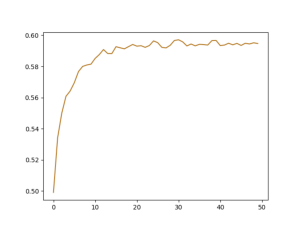

In [ ]:
import matplotlib.pyplot as plt
import cv2
acc_plot = cv2.imread('val_acc_SCA-Base-try4.png')
plt.imshow(acc_plot)
plt.axis('off')

## Result & Visualization

### Retrieve the model 

In [5]:
import torch
import model

log = torch.load('logs/SCA-Base-new-try4.pth') #strong base 2022-04-22_02/43/55.pth
tokens = len(log['vocab']['question']) + 1

net = torch.nn.DataParallel(model.Net_SCA(tokens)).to(device) # Net: strong base / Net0: shallow base
net.load_state_dict(log['weights'])

/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:831: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:574: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


<All keys matched successfully>

In [6]:
import summary

summary.get_accuracy(net)

average accuracy is 0.6350603103637695 
 accuracy for Y/N is 0.8158159255981445 
 accuracy for Num is 0.5313003659248352 
 accuracy for others is 0.5031496286392212


In [10]:
import utils 
utils.count_parameters(net)

+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
|  module.text.embedding.weight  |  1440600   |
| module.text.lstm.weight_ih_l0  |  1228800   |
| module.text.lstm.weight_hh_l0  |  4194304   |
|  module.text.lstm.bias_ih_l0   |    4096    |
|  module.text.lstm.bias_hh_l0   |    4096    |
| module.attention.v_conv.weight |   262144   |
| module.attention.q_lin.weight  |   524288   |
|  module.attention.q_lin.bias   |    512     |
| module.attention.x_conv.weight |    1024    |
|  module.attention.x_conv.bias  |     2      |
|  module.channel_attention.W_c  |    512     |
| module.channel_attention.W_hc  |   524288   |
|  module.channel_attention.W_i  |    512     |
|  module.channel_attention.b_c  |    512     |
|  module.channel_attention.b_i  |     1      |
| module.classifier.lin1.weight  |  2097152   |
|  module.classifier.lin1.bias   |    1024    |
| module.classifier.lin2.weight  |  3072

13358867

#### Question and answer encoding 

In [8]:
import visualization 

10000
found 10000 images in ../image_dataset_abs/val2015


question 2 of the image 24838
 Is there clouds in the sky? 

['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
Top three output ['yes', 'no', '2'] and probability [0.6410815 0.3552569 0.00167  ]


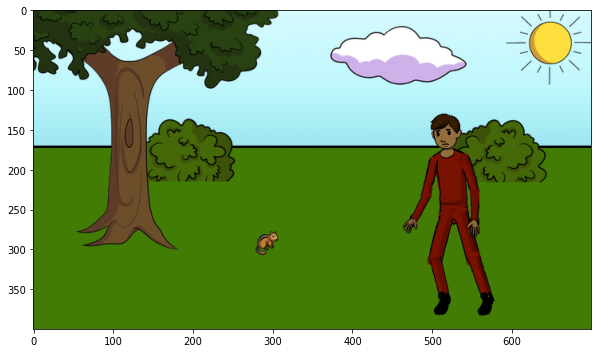

In [9]:
image_item = 70
question_item = 2
visualization.out_result(net, device, image_item, question_item)

### Visualization of the attention 

question 1 of the image 28042
 Could this be a romantic date? 

['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
Top three output ['yes', 'no', 'maybe'] and probability [0.5903743 0.4030682 0.0052421]
question 1 of the image 28042
 Could this be a romantic date? 

channel attention with weight [0.00203043 0.00202953 0.00202767]


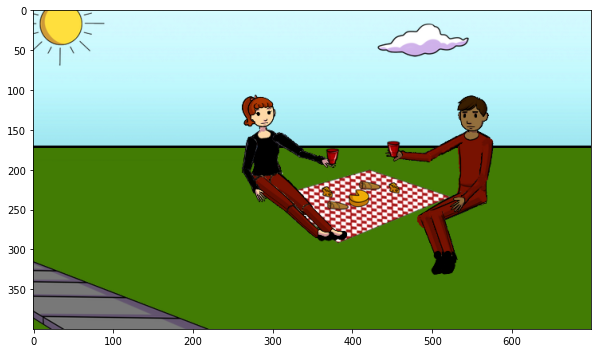

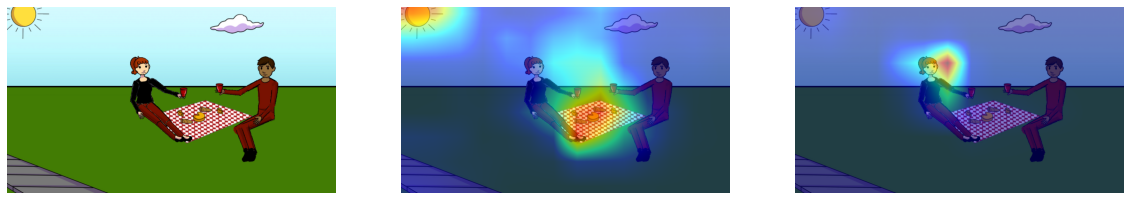

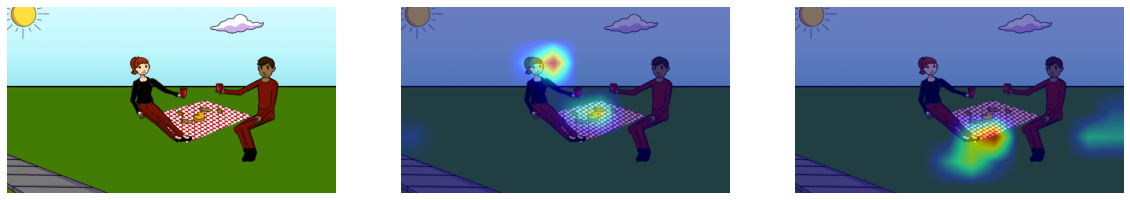

In [15]:
image_id = 122
question_id = 1
visualization.out_result(net, device, image_id, question_id)
visualization.out_attention(net, device, image_id, question_id, spatial = True, channel = True)